In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    fbeta_score,
    f1_score,
    make_scorer,
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA


from xgboost import XGBClassifier

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
feat_30_loc = "../data/features_30_sec.csv"
feat_3_loc = "../data/features_3_sec.csv"
# named long and short to differentiate easier
long = pd.read_csv(feat_30_loc)
short = pd.read_csv(feat_3_loc)

<IPython.core.display.Javascript object>

In [5]:
# log transform variances
var_cols = short.columns[short.columns.str.contains("_var")]
logged_var_df = short.copy()
# for col in var_cols:
#     logged_var_df[col + "_logged"] = np.log(logged_var_df[col])
#     logged_var_df = logged_var_df.drop(col, 1)

<IPython.core.display.Javascript object>

In [6]:
m_start = 12  # highest mfcc to use. higher than this is too high in the frequency spectrum to really matter
mel_freq_drops = [f"mfcc{x}_mean" for x in range(m_start, 21)] + [
    f"mfcc{x}_var_logged" for x in range(m_start, 21)
]

<IPython.core.display.Javascript object>

In [7]:
drop_cols = ["filename", "length", "label"]
# drop_cols = drop_cols + mel_freq_drops
X = logged_var_df.drop(drop_cols, 1)
y = logged_var_df["label"]

<IPython.core.display.Javascript object>

In [8]:
scaler = StandardScaler()

# 'learn' from the data
scaler.fit(X)

# apply what the scaler learned
scaled_X = scaler.transform(X)
scaled_df = pd.DataFrame(scaled_X, columns=X.columns)

<IPython.core.display.Javascript object>

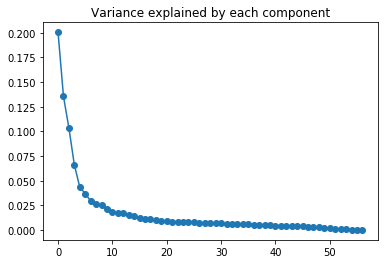

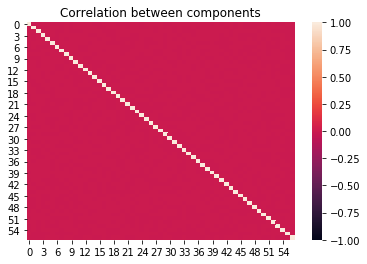

<IPython.core.display.Javascript object>

In [9]:
pca = PCA()

# 'learn' from the data
pca.fit(scaled_X)

# apply what the pca object learned
pca_X = pca.transform(scaled_X)

# What attribute holds the variance explained?
plt.plot(pca.explained_variance_ratio_, marker="o")
plt.title("Variance explained by each component")
plt.show()

sns.heatmap(pd.DataFrame(pca_X).corr(), vmin=-1, vmax=1)
plt.title("Correlation between components")
plt.show()

In [10]:
pd.concat((X, pd.DataFrame(pca_X)), axis="columns").corr()[
    [0, 1, 2, 3]
].style.background_gradient()

,0,1,2,3
chroma_stft_mean,0.037158,-0.779165,0.032603,-0.211937
chroma_stft_var,0.494705,0.413385,0.109649,-0.127240
rms_mean,0.268887,-0.652899,0.003213,0.071121
rms_var,0.622039,-0.308668,0.064265,-0.042608
spectral_centroid_mean,0.330098,-0.811533,-0.009336,0.289189
spectral_centroid_var,0.771035,-0.291623,-0.035213,-0.201417
spectral_bandwidth_mean,0.469035,-0.724642,-0.174566,0.195242
spectral_bandwidth_var,0.608700,0.032994,-0.095785,-0.415479
rolloff_mean,0.358751,-0.810006,-0.044215,0.254303
rolloff_var,0.702508,-0.077693,-0.097070,-0.368822


<IPython.core.display.Javascript object>

In [11]:
pca = PCA(n_components=5)

# 'learn' from the data
pca.fit(scaled_X)

# apply what the pca object learned
pca_X = pca.transform(scaled_X)

<IPython.core.display.Javascript object>

In [12]:
model = XGBClassifier(n_jobs=-1)
model.fit(pca_X, y)
# In practice score on a test set
model.score(pca_X, y)

0.9558558558558559

<IPython.core.display.Javascript object>

In [13]:
X = logged_var_df.drop(drop_cols, 1,)
y = logged_var_df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=34, stratify=y
)

<IPython.core.display.Javascript object>

In [14]:
num_cols = list(X.columns)

bin_cols = []

cat_cols = []
drop_cats = []

pca_n = 5

preprocessing = ColumnTransformer(
    [
        # Scale numeric columns (not needed for all models but can't hurt)
        ("scaler", StandardScaler(), num_cols)
    ],
    remainder="passthrough",
)


pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("pca", PCA(n_components=pca_n)),
        # Choose your model and put it here
        ("xgb", XGBClassifier()),
    ]
)


params = {
    "xgb__subsample": [0.5, 0.75, 1.0],
    "xgb__colsample_bytree": [0.4, 0.6, 0.8, 1.0],
    "xgb__max_depth": [6, 8, 10],
}

n_trees = 100
learning_rate = 6 / n_trees

pipeline["xgb"].n_estimators = n_trees
pipeline["xgb"].learning_rate = learning_rate

# apply transformations for the evaluation set
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(pca_n)
pca.fit(X_train_scaled)
pca_X_test = pca.transform(X_test_scaled)


pipeline_cv = GridSearchCV(pipeline, params, verbose=1, n_jobs=-1, cv=2)

pipeline_cv.fit(
    X_train, y=y_train, xgb__eval_set=[(pca_X_test, y_test)],
)


print(pipeline_cv.score(X_train, y_train))
print(pipeline_cv.score(X_test, y_test))
pipeline_cv.best_params_

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   25.9s


[0]	validation_0-merror:0.52653
[1]	validation_0-merror:0.49199
[2]	validation_0-merror:0.46497


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   52.1s finished


[3]	validation_0-merror:0.45646
[4]	validation_0-merror:0.44745
[5]	validation_0-merror:0.43494
[6]	validation_0-merror:0.43494
[7]	validation_0-merror:0.42943
[8]	validation_0-merror:0.42893
[9]	validation_0-merror:0.43343
[10]	validation_0-merror:0.42292
[11]	validation_0-merror:0.42192
[12]	validation_0-merror:0.41592
[13]	validation_0-merror:0.41491
[14]	validation_0-merror:0.41341
[15]	validation_0-merror:0.41592
[16]	validation_0-merror:0.41742
[17]	validation_0-merror:0.41692
[18]	validation_0-merror:0.41441
[19]	validation_0-merror:0.41491
[20]	validation_0-merror:0.41541
[21]	validation_0-merror:0.41541
[22]	validation_0-merror:0.41541
[23]	validation_0-merror:0.41942
[24]	validation_0-merror:0.41541
[25]	validation_0-merror:0.41592
[26]	validation_0-merror:0.41541
[27]	validation_0-merror:0.41792
[28]	validation_0-merror:0.41692
[29]	validation_0-merror:0.41642
[30]	validation_0-merror:0.41241
[31]	validation_0-merror:0.41041
[32]	validation_0-merror:0.41241
[33]	validation_0

{'xgb__colsample_bytree': 0.8, 'xgb__max_depth': 10, 'xgb__subsample': 0.75}

<IPython.core.display.Javascript object>